# Task 2 notebook

This codes aims to do unsupervised learning over multiple TF to class them, as well a defining some kind of "closeness" between them.
This is done using PCA over the features and then KMEAN to classify the TF.

In [1]:
#import libraries needed
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

import math
import cv2
from skimage import measure
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


In [2]:
#Outlier removal definition
def outlier_removal(without_outliers, **kwargs):
    #define input parameters
    outlier_range =   kwargs['outlier_range']
    outlier_columns = kwargs['outlier_columns'] 
    interquantile =   kwargs['interquantile']
    quantile_keep =   kwargs['interquantile']
    # first choose which method for outlier removal wants to be used. Use a for loop to iterate over the defined columns of the dataframe.
    if interquantile == True:
        for col in outlier_columns:
            # defined the interquantile range and then the upper and lower limit of the choosen column
            median = without_outliers[col].median()
            q_75 = without_outliers[col].quantile(q = 0.75)
            q_25 = without_outliers[col].quantile(q = 0.25)
            interquantile = q_75 - q_25                              
            upper_bound = median + (interquantile * outlier_range)
            lower_bound = median - (interquantile * outlier_range)

            # Create a boolean mask that is True for rows with a value less than or equal to the upper limit and higher or equal to the lower limit
            mask = (without_outliers[col] <= upper_bound) & (without_outliers[col] >= lower_bound)
            # Use the mask to filter the dataframe
            without_outliers = without_outliers[mask]
    else: 
        for col in outlier_columns:
            #define the limit up to which the values are kept
            quantile_limit = without_outliers[col].quantile(q = 0.95)
            #define a boolean mask that is True for rows that are in the defined limit
            mask = without_outliers[col] < quantile_limit
            #use the mask to filter the dataframe
            without_outliers = without_outliers[mask]
        
    return without_outliers


# Data loading

In [3]:
df_A1 = pd.read_csv ('../Features/TF1_A1.csv',index_col = 0)
df_C7 = pd.read_csv ('../Features/TF1_C7.csv',index_col = 0)
df_D8 = pd.read_csv ('../Features/TF1_D8.csv',index_col = 0)


In [4]:
ypet_intensity = pd.concat((df_A1,df_C7,df_D8),ignore_index = False)
ypet_intensity

,patch,img,TF_name,blur_lapl,blur_ski,patch_size,mean_intensity,sum_intensity,median_intensity,standard_deviation,...,gabro_15,lbp_0,lbp_1,lbp_2,lbp_3,lbp_4,lbp_5,lbp_6,lbp_7,Circularity
0,patch_20,1,A - 1,False,False,1648,1998.089199,3292851,1858.0,505.355583,...,0.034091,0.163976,0.157179,0.107901,0.126593,0.106202,0.107901,0.105353,0.124894,0.837007
1,patch_21,1,A - 1,False,False,1407,1637.015636,2303281,1596.0,290.282851,...,0.007212,0.234428,0.193658,0.097395,0.104190,0.066818,0.071348,0.078143,0.154020,0.824973
2,patch_22,1,A - 1,False,False,396,2425.272727,960408,2395.0,232.739898,...,0.031250,0.202847,0.192171,0.106762,0.124555,0.081851,0.064057,0.067616,0.160142,0.939736
3,patch_23,1,A - 1,False,False,222,1679.067568,372753,1470.0,547.246111,...,0.011029,0.134078,0.150838,0.134078,0.128492,0.162011,0.089385,0.078212,0.122905,0.998029
4,patch_24,1,A - 1,False,False,512,1586.785156,812434,1666.5,297.113202,...,0.027500,0.134663,0.137157,0.107232,0.147132,0.139651,0.129676,0.077307,0.127182,0.933676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,patch_671,12,D - 8,False,False,1058,1048.496219,1109309,882.0,417.352793,...,0.004032,0.182944,0.162311,0.122421,0.111417,0.110041,0.094911,0.071527,0.144429,0.632760
636,patch_672,12,D - 8,False,False,2020,790.168317,1596140,757.0,163.446456,...,0.031250,0.207547,0.195472,0.098113,0.104151,0.065660,0.083774,0.093585,0.151698,0.857790
637,patch_674,12,D - 8,False,False,1327,679.620196,901856,680.0,51.061428,...,0.040948,0.238717,0.178147,0.093824,0.091449,0.060570,0.078385,0.078385,0.180523,0.711856
638,patch_675,12,D - 8,False,False,1093,838.932296,916953,798.0,136.880548,...,0.154514,0.228412,0.204735,0.083565,0.093315,0.064067,0.079387,0.096100,0.150418,0.847612


# Preprocessing

## Parameters to adapt for the data processing

In [5]:
#parameters to adapt for analyzation:
#outlier removal
outlier = True              #If outliers in general should be removed True, if not False
interquantile = True        #if outliers should be removed by defining a range with the interquantile: True; to remove outliers just when they're exceeding a certain quantile: False
quantile_keep = 0.95        #to change if interquantile = False; else ignore
outlier_columns = ['mean_intensity'] #choose columns of which the outliers should be removed. to choose all the columns: list(ypet_intensity_processed)[6:]
outlier_range = 1.5         #if interquantile = True defined this value to define the range. Gets multiplicated with interquantile. Else ignore
#Normalization
normalization = True
columns_to_be_normalized =  ['patch_size','mean_intensity','median_intensity','sum_intensity','variance','area_Test'] #list(ypet_intensity_processed)[6:]  #if all columns should be normalized
                             #take logs to reduce skewness
take_log = False             #want to take the log of certain columns
columns_log = ['mean_intensity']    #needs pre-analyzation of columns if log is needed. 
                                    #With a histogram it can be seen if the distribution is skewed. 
ypet_intensity_processed = ypet_intensity.copy()

## Outlier removal in columns of the dataframes

In [6]:
#apply the function for outlier removal
if outlier == True:
    #group by the TF and just cut the outliers for one TF
    without_outliers = ypet_intensity_processed.groupby('TF_name',as_index=False).apply(outlier_removal, outlier_range=outlier_range, outlier_columns=outlier_columns, interquantile = interquantile, quantile_keep=quantile_keep).reset_index()
    #change index so dataframe is as before
    without_outliers = without_outliers.drop(['level_0'],axis=1)
    without_outliers = without_outliers.set_index('level_1')
    without_outliers.index.name = None
    #save it under a new dataframe
    ypet_intensity_processed = without_outliers.copy()

#take logs of certain columns that are skewed
if take_log == True:
    TF_grouped = ypet_intensity_processed.groupby('TF_name')
    log_rows = TF_grouped[columns_log].transform(lambda x: np.log(x))
    ypet_intensity_processed[columns_log] = log_rows
    
# Normalization of columns of the dataframe
if normalization == True:
    TF_grouped = ypet_intensity_processed.groupby('TF_name')
    Normalized_columns = TF_grouped[columns_to_be_normalized].transform(lambda x: (x - x.mean()) / x.std()) #removed rows_to_be to have all col normalized

    # Replace normalized
    ypet_intensity_processed[columns_to_be_normalized] = Normalized_columns                         


# Task 2: Unsupervised clustering

### Parameters to define

In [7]:
n_components = 2            #For PCA how many components to keep at the end
pca_excluded = ['img', 'TF_name', 'blur_lapl', 'blur_ski','patch'] #define which columns should be excluded -> No additional information for the PCA
random_state = 42           #input for the Kmeans algorithm to determines random number generation for centroid initialization
n_clusters = 5              # Number of clusters we want for TF


In [8]:
#Check how many datapoints each TF has and which TF has least values. Take according to that some random points.  (So that we have the same amount of datapoint for each TF). 
min_d =  ypet_intensity.groupby('TF_name').count().min()[0]


#take same amount of points per TF
TF_names = ypet_intensity.TF_name.unique()
extracted_i = []

for i in (TF_names):
    # indices of all the points from X that belong to cluster i
    C_i = np.where(ypet_intensity.TF_name == i)[0].tolist() 

    # indices of the points from X to be sampled from cluster i
    sample_i = np.random.choice(C_i, min_d,replace=False).tolist()
    extracted_i.extend(sample_i) 
extracted_points = ypet_intensity.iloc[extracted_i]   

extracted_points

,patch,img,TF_name,blur_lapl,blur_ski,patch_size,mean_intensity,sum_intensity,median_intensity,standard_deviation,...,gabro_15,lbp_0,lbp_1,lbp_2,lbp_3,lbp_4,lbp_5,lbp_6,lbp_7,Circularity
1646,patch_758,2,A - 1,False,False,821,2121.913520,1742091,2126.0,375.252618,...,0.044118,0.120690,0.123824,0.134796,0.175549,0.144201,0.119122,0.098746,0.083072,0.845434
753,patch_786,1,A - 1,False,False,984,2430.414634,2391528,2507.0,404.784923,...,0.038194,0.119845,0.103093,0.130155,0.175258,0.132732,0.152062,0.096649,0.090206,0.932491
894,patch_933,1,A - 1,False,False,316,2466.145570,779302,2481.5,403.939286,...,0.013889,0.101887,0.098113,0.162264,0.203774,0.139623,0.143396,0.071698,0.079245,0.913239
5829,patch_99,11,A - 1,False,False,849,3687.698469,3130856,3713.0,344.812741,...,0.025338,0.181513,0.147899,0.126050,0.154622,0.084034,0.095798,0.082353,0.127731,0.882000
5204,patch_601,8,A - 1,False,False,1794,1240.606466,2225648,1240.0,110.132256,...,0.032955,0.195222,0.182867,0.104613,0.115321,0.074959,0.083196,0.084843,0.158979,0.828116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,patch_53,11,D - 8,False,False,2193,868.399453,1904400,820.0,159.662106,...,0.024254,0.221038,0.191898,0.091684,0.101635,0.072495,0.086709,0.080313,0.154229,0.799305
83,patch_95,3,D - 8,False,False,1335,810.172285,1081580,802.0,86.722815,...,0.035560,0.225256,0.167235,0.125142,0.100114,0.070535,0.085324,0.084187,0.142207,0.757565
32,patch_53,10,D - 8,False,False,1498,1058.761015,1586024,818.0,469.473014,...,0.080357,0.194146,0.151220,0.111220,0.120976,0.110244,0.085854,0.065366,0.160976,0.786468
616,patch_656,2,D - 8,False,False,1734,984.600346,1707297,997.0,212.121616,...,0.150815,0.161501,0.137031,0.114192,0.132953,0.135400,0.111746,0.077488,0.129690,0.917304


### Apply a principal component analysis (PCA) and prepare dataframe for clustering

In [9]:
pca = PCA(n_components)
ypet_intensity = extracted_points

# define which columns should be excluded
to_test = ypet_intensity.drop(pca_excluded, axis = 1)

# Check how much variance the PCA components explain
pca_result = pca.fit(to_test)
print(pca_result.explained_variance_ratio_)

# apply the dimensionality reduction on data
pca_components = pca.fit_transform(to_test)

# Combine excluded data and pca
ypet_intensity_pca = ypet_intensity[pca_excluded]
for iter_i in range(n_components):
    name = 'pca_component_' + str(iter_i)
    ypet_intensity_pca[name] = pca_components[:,iter_i]

[0.84734193 0.15265789]


C:\Users\alexi\AppData\Local\Temp\ipykernel_15640\2993404782.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ypet_intensity_pca[name] = pca_components[:,iter_i]
C:\Users\alexi\AppData\Local\Temp\ipykernel_15640\2993404782.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ypet_intensity_pca[name] = pca_components[:,iter_i]


In [10]:
ypet_cluster = ypet_intensity_pca.reset_index().set_index(['index','patch','img','TF_name','blur_lapl','blur_ski'])


### Apply Kmean clustering algorithm

In [11]:
#apply KMeans algorithm
kmean = KMeans(n_clusters=n_clusters, random_state=random_state).fit(ypet_cluster)

#save as new dataframe and add column for clustering label
ypet_clustered = ypet_cluster.copy()
ypet_clustered['cluster'] = kmean.labels_

### Visualization of the results

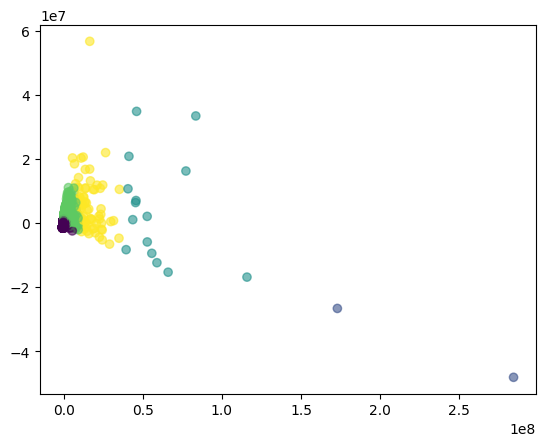

In [12]:
plt.scatter(ypet_cluster.iloc[:,0], ypet_cluster.iloc[:,1], c=kmean.labels_, alpha=0.6)

### Analysis of the results

In [13]:
# Find more information
min_n = ypet_clustered.groupby('cluster').count().min()[0] #min number of points i n a cluster
max_n = ypet_clustered.groupby('cluster').count().max()[0] #min number of points i n a cluster
print(min_n, max_n)

test = ypet_clustered[ypet_clustered['cluster'] == 0]
print("Cluster 0:")
print(test.groupby('TF_name').count())

test = ypet_clustered[ypet_clustered['cluster'] == 3]
print("Cluster 3:")
print(test.groupby('TF_name').count())

2 14690
Cluster 0:
         pca_component_0  pca_component_1  cluster
TF_name                                           
A - 1               4188             4188     4188
C - 7               5073             5073     5073
D - 8               5429             5429     5429
Cluster 3:
         pca_component_0  pca_component_1  cluster
TF_name                                           
A - 1               1245             1245     1245
C - 7                406              406      406
D - 8                 72               72       72


In [14]:
# Extract x percentage of data per cluster -> easier to analyze
extracted_i = []
x = 0.9

for i in range(n_clusters):

    # indices of all the points from X that belong to cluster i
    C_i = np.where(kmean.labels_ == i)[0].tolist() 
    n_i = len(C_i) # number of points in cluster i

    # indices of the points from X to be sampled from cluster i
    sample_i = np.random.choice(C_i, math.ceil((x * n_i))).tolist()
    extracted_i.extend(sample_i) 
    
ypet_clustered.iloc[np.unique(extracted_i)]
    

,,,,,,pca_component_0,pca_component_1,cluster
index,patch,img,TF_name,blur_lapl,blur_ski,,,
753,patch_786,1,A - 1,False,False,49792.229428,7.519401e+05,0
894,patch_933,1,A - 1,False,False,-345962.652989,-8.109578e+05,0
2123,patch_299,3,A - 1,False,False,-295941.864504,-1.710858e+05,0
4922,patch_317,8,A - 1,False,False,-132552.192467,2.440992e+05,0
2055,patch_230,3,A - 1,False,False,326985.734577,1.415965e+06,3
...,...,...,...,...,...,...,...,...
654,patch_688,5,D - 8,False,False,-383213.352260,-3.170269e+05,0
201,patch_225,9,D - 8,False,False,-478787.129025,-7.041685e+05,0
45,patch_53,11,D - 8,False,False,-203724.005442,3.135707e+05,0


***
# Visualizations (Exploration phase)

#### Tune blur

In [15]:
plt.imshow(cv2.Laplacian(variance_data_list[test], cv2.CV_64F), cmap='gray')


NameError: name 'variance_data_list' is not defined

In [ ]:
cv2.Laplacian(variance_data_list[test], cv2.CV_64F).var()

In [ ]:
measure.blur_effect(variance_data_list[test])

#### Mask, nucleus

In [ ]:
plt.imshow(boolean, cmap='gray')
plt.imshow(patch_data, cmap='gray')
test = 31
plt.imshow(variance_data_list[test], cmap='gray')
plt.imshow(patch_data_list[test], cmap='gray')

## Local binary patterns

In [ ]:
# Visualize lpb
METHOD = 'uniform'   
radius = 1
n_points = 8 * radius
image = patch_data

lbp = local_binary_pattern(image, n_points, radius, METHOD)

    
def overlay_labels(image, lbp, labels):
    mask = np.logical_or.reduce([lbp == each for each in labels])
    return label2rgb(mask, image=image, bg_label=0, alpha=0.5)


def highlight_bars(bars, indexes):
    for i in indexes:
        bars[i].set_facecolor('r')
def hist(ax, lbp):
    n_bins = int(lbp.max() + 1)
    return ax.hist(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins),
                   facecolor='0.5')


# plot histograms of LBP of textures
fig, (ax_img, ax_hist) = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
plt.gray()

titles = ('edge', 'flat', 'corner')
w = width = radius - 1
edge_labels = range(n_points // 2 - w, n_points // 2 + w + 1)
flat_labels = list(range(0, w + 1)) + list(range(n_points - w, n_points + 2))
i_14 = n_points // 4            # 1/4th of the histogram
i_34 = 3 * (n_points // 4)      # 3/4th of the histogram
corner_labels = (list(range(i_14 - w, i_14 + w + 1)) +
                 list(range(i_34 - w, i_34 + w + 1)))

label_sets = (edge_labels, flat_labels, corner_labels)

for ax, labels in zip(ax_img, label_sets):
    ax.imshow(overlay_labels(image, lbp, labels))

for ax, labels, name in zip(ax_hist, label_sets, titles):
    counts, _, bars = hist(ax, lbp)
    highlight_bars(bars, labels)
    ax.set_ylim(top=np.max(counts[:-1]))
    ax.set_xlim(right=n_points + 2)
    ax.set_title(name)

ax_hist[0].set_ylabel('Percentage')
for ax in ax_img:
    ax.axis('off')



In [ ]:
# Remove background    

# plot histograms of LBP of textures
fig, (ax_img, ax_hist) = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
plt.gray()

titles = ('edge', 'flat', 'corner')
w = width = radius - 1
edge_labels = range(n_points // 2 - w, n_points // 2 + w + 1)
flat_labels = list(range(0, w + 1)) # Remove background: list(range(n_points - w, n_points + 2))
i_14 = n_points // 4            # 1/4th of the histogram
i_34 = 3 * (n_points // 4)      # 3/4th of the histogram
corner_labels = (list(range(i_14 - w, i_14 + w + 1)) +
                 list(range(i_34 - w, i_34 + w + 1)))

label_sets = (edge_labels, flat_labels, corner_labels)



for ax, labels in zip(ax_img, label_sets):
    ax.imshow(overlay_labels(image, lbp, labels))

for ax, labels, name in zip(ax_hist, label_sets, titles):
    counts, _, bars = hist(ax, lbp)   
    highlight_bars(bars, labels)
    ax.set_ylim(top=np.max(counts[:-1]))
    ax.set_xlim(right=n_points + 2)
    ax.set_title(name)

ax_hist[0].set_ylabel('Percentage')
for ax in ax_img:
    ax.axis('off')

# Drop background
count = len(np.unique(lbp))
H, bins = np.histogram(lbp, count)

# Drop background values
fig, ax = plt.subplots(figsize=(12, 8))
index_background = n_points - w
H = H[0: index_background]
bins =  bins[0: index_background]

plt.bar(bins,H,width=1)
